In [1]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import numpy as np

Task 1) Import all csv files, without the meta data files

In [2]:
dir_path = './data'
csv_file_names = []

for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        if path.find('.csv') != -1:
            csv_file_names.append(path)

Append all csv files to a list of dataframes and add the id of the sensor to distinguish them later on

In [3]:
list_df = []
sensor_names = []

for filename in csv_file_names:
    df = pd.read_csv('./data/' + filename, index_col=None, header=0)
    df['Time'] = df.apply(lambda row: datetime.strptime(row['Time'], '%Y-%m-%d %H:%M:%S'), axis=1)

    sensor_names.append(filename[12:16])
    list_df.append(df)

list_len = [len(df) for df in list_df]

Remove all measurements with a timestamp not inbetween 2022.02.20 00:00:00 to 2022.03.04 24:00:00, set the timestamp as index of the dataframe, and add the start and end timestamp of the measurement period to the dataframe it doesn't exist

In [4]:
start_time = datetime.strptime('2022.02.20 00:00:00', '%Y.%m.%d %H:%M:%S')
end_time = datetime.strptime('2022.03.05 00:00:00', '%Y.%m.%d %H:%M:%S')

for df in list_df:
    df = df[df.Time >= start_time]
    df = df[df.Time <= end_time]

    start_row = pd.DataFrame({'Time': start_time, 'dt_sound_level_dB': df.iloc[0]['dt_sound_level_dB']}, index=[0])
    start_row['Time'] = pd.to_datetime(start_row['Time'])

    end_row = pd.DataFrame({'Time': end_time, 'dt_sound_level_dB': df.iloc[-1]['dt_sound_level_dB']}, index=[0])
    end_row['Time'] = pd.to_datetime(end_row['Time'])

    df['Time'] = pd.to_datetime(df['Time'])
    df = df.set_index('Time')

    if not (df.index == end_time).any():
        df.loc[end_time] = [df.iloc[-1]['dt_sound_level_dB']]

    if not (df.index == start_time).any():
        df.loc[start_time] = [df.iloc[0]['dt_sound_level_dB']]

    df = df.sort_values(by='Time')

Convert the time series to equally-spaced data with one minute time intervals and interpolate missing data with the "nearest" interpolant. Therefore, let's insert all missing timestamps first, join existing measurements and finally interpolate missing values.

In [5]:
import datetime

dt = start_time
step = datetime.timedelta(minutes=1)
result = []

while dt < end_time:
    result.append(dt.strftime('%Y.%m.%d %H:%M:%S'))
    dt += step

col = {'Time': result, 'dt_sound_level_dB': 0}
df_all_timestamps = pd.DataFrame(data=col)
df_all_timestamps['Time'] = pd.to_datetime(df_all_timestamps['Time'])
df_all_timestamps = df_all_timestamps.set_index('Time')

Task 2) Interpolate missing data

In [6]:
list_df_inter = []
for df in list_df:
    df_complete = df_all_timestamps.merge(df, how='left', on='Time')
    df_complete = df_complete.drop('dt_sound_level_dB_x', axis=1)
    while df_complete['dt_sound_level_dB_y'].isnull().values.any():
        df_complete = df_complete.interpolate(method='bfill', limit=1)
        df_complete = df_complete.interpolate(method='ffill', limit=1)
    list_df_inter.append(df_complete)

Resample to eliminate rows not corresponding to our sampling frequency

In [7]:
for df in list_df_inter:
    df = df.set_index('Time')
    df = df.resample('1T').mean()

Task 3) Construct Lag plots for lags 1, 10, 60 and 720 for one sensor (for all sensors it would be 48 plots)

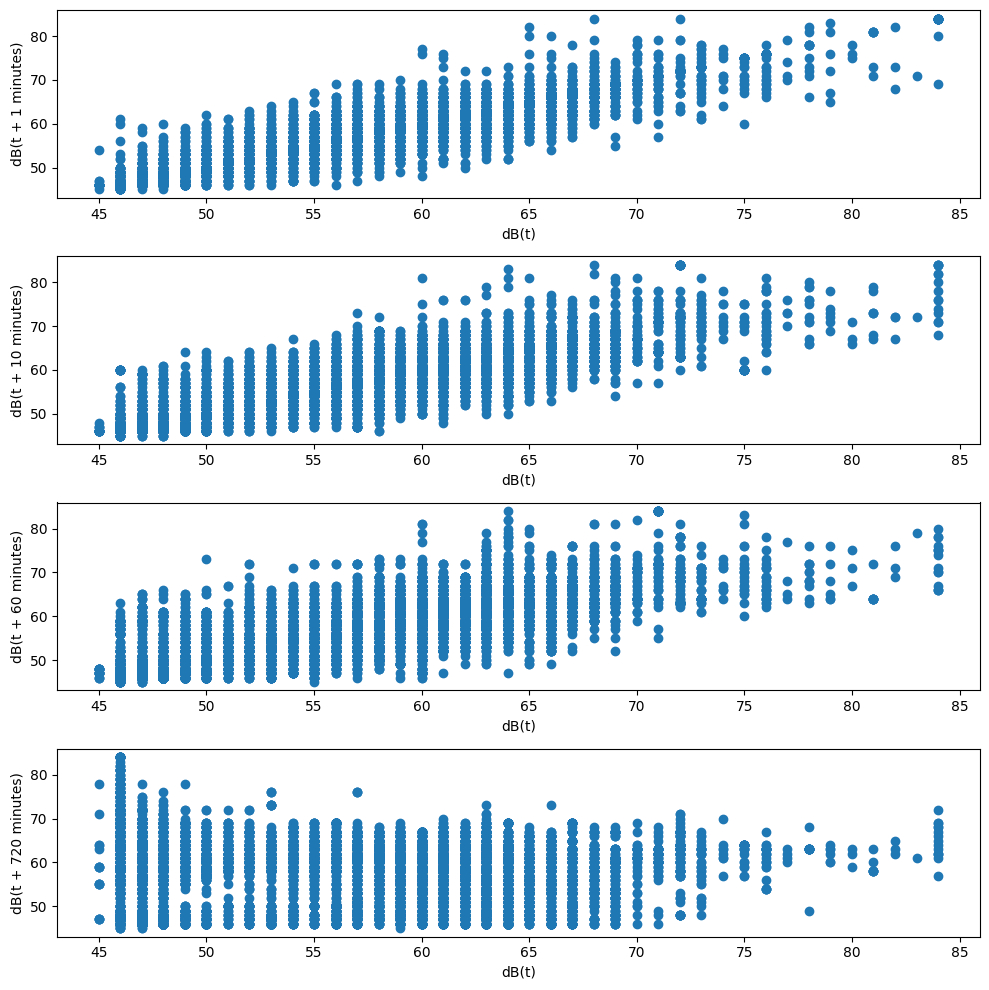

In [8]:
lags = [1, 10, 60, 720]
figure, axis = plt.subplots(4, 1, figsize=(10, 10))

for i, lag in enumerate(lags):
    pd.plotting.lag_plot(list_df_inter[0]['dt_sound_level_dB_y'], lag=lag, ax=axis[i])
    axis[i].set_xlabel('dB(t)')
    axis[i].set_ylabel(f'dB(t + {lag} minutes)')

plt.tight_layout()
plt.show()

Compute R2 values for each lag plot

In [9]:
for lag in lags:
    for i, df in enumerate(list_df_inter):
        y_pred = df['dt_sound_level_dB_y'].iloc[lag:]
        y_true = df['dt_sound_level_dB_y'].iloc[:-lag]
        r2 = r2_score(y_true, y_pred)
        print(f'R2 coefficient for sensor {sensor_names[i]} and lag {lag}: {r2}')

    print('-----------')

R2 coefficient for sensor 2004 and lag 1: 0.9271752878234366
R2 coefficient for sensor 2018 and lag 1: 0.9164398209036353
R2 coefficient for sensor 201D and lag 1: 0.8993051858498502
R2 coefficient for sensor 2024 and lag 1: 0.8379126580106946
R2 coefficient for sensor 206D and lag 1: 0.9040583892751926
R2 coefficient for sensor 2071 and lag 1: 0.8948961980491237
R2 coefficient for sensor 2078 and lag 1: 0.8939438287023153
R2 coefficient for sensor 2095 and lag 1: 0.8860499027303524
R2 coefficient for sensor 20A6 and lag 1: 0.9257877200612783
R2 coefficient for sensor 2148 and lag 1: 0.932735115032579
R2 coefficient for sensor 230F and lag 1: 0.8917677284332143
R2 coefficient for sensor 2349 and lag 1: 0.9302850515939504
-----------
R2 coefficient for sensor 2004 and lag 10: 0.8369871334457814
R2 coefficient for sensor 2018 and lag 10: 0.8198756011931311
R2 coefficient for sensor 201D and lag 10: 0.7853347109195365
R2 coefficient for sensor 2024 and lag 10: 0.6638763525095887
R2 coeffi

Task 4) Interpretation of R2 coefficients:
It appears that there is a strong positive correlation between the sound level measured by each sensor and the lagged sound level at a lag of 1 minute, with R2 values ranging sligthly below 1. As the lag increases, the correlation becomes weaker, with R2 values ranging around 0.5 for a lag of 60 minutes. For a lag of 720 minutes, there is a negative correlation, which indicate that the model doesn't follow the trend of data at all (switched to non-deterministic).

Task 5) Randomly resample the data from three stations using a uniform distribution with sample sizes of 1%, 5%, 10%, 50% and 90%. Plot the three statistical parameters mean, median and standard deviation as a function of the sample percentage for each site.
Stations: 206D, 201D (next to each other), 2004 (further away)

In [10]:
sample_sizes = [0.01, 0.05, 0.1, 0.5, 0.9]
stats = ['mean', 'median', 'std']

data = [list_df_inter[4], list_df_inter[3], list_df_inter[0]]
sensor_names = ['206D', '201D', '2004']
means = []
medians = []
stds = []

for df in data:
    mean_list = []
    median_list = []
    std_list = []

    for size in sample_sizes:
        sample_size = int(size * len(df))
        sample = df.sample(n=sample_size, replace=False)
        mean_list.append(np.mean(sample['dt_sound_level_dB_y']))
        median_list.append(np.median(sample['dt_sound_level_dB_y']))
        std_list.append(np.std(sample['dt_sound_level_dB_y']))

    means.append(mean_list)
    medians.append(median_list)
    stds.append(std_list)

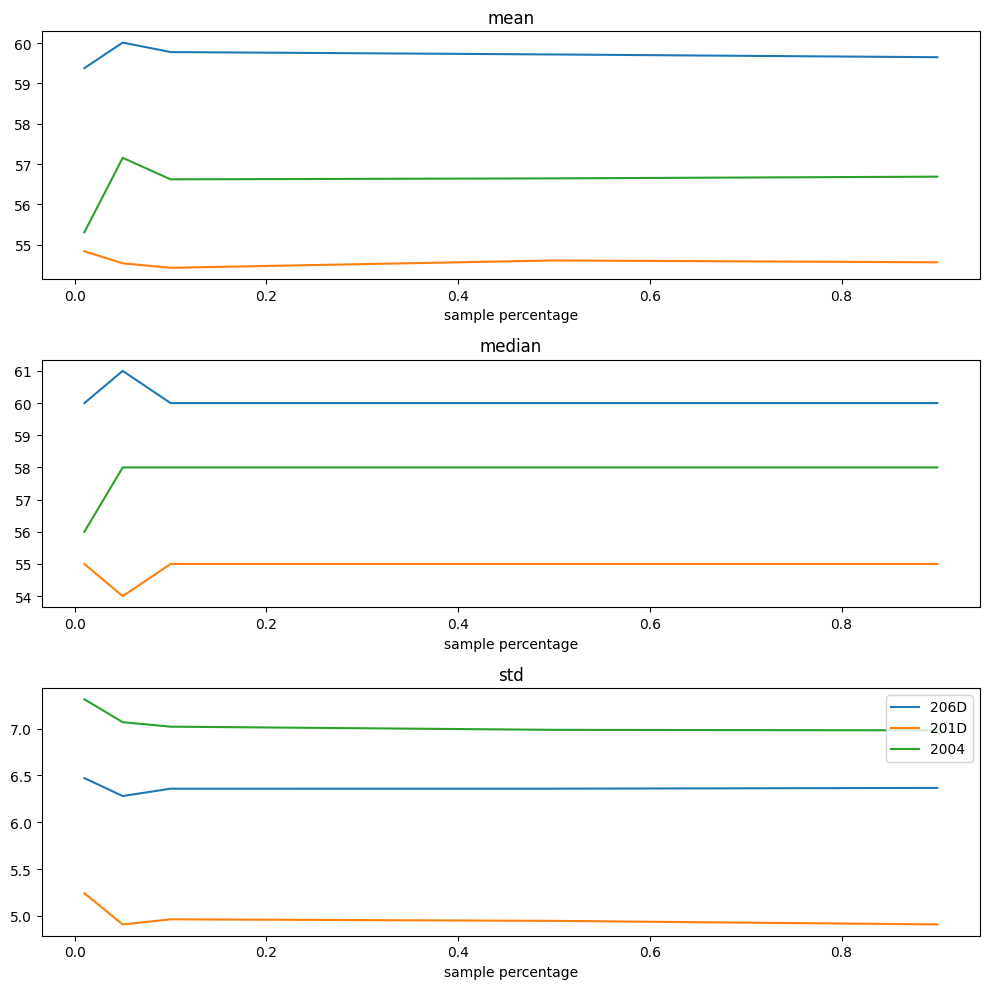

In [11]:
fig, ax = plt.subplots(3, figsize=(10, 10))
stat_data = [means, medians, stds]

for axis in range(3):
    for i, name in enumerate(sensor_names):
        ax[axis].plot(sample_sizes, stat_data[axis][i], label=name)

    ax[axis].set_title(stats[axis])
    ax[axis].set_xlabel('sample percentage')

fig.tight_layout()
plt.legend()
plt.show()

Plot the same three statistical parameters, but as ensembles
1. Ensemble: 206D, 2004 (far from each other)
2. All three


In [12]:
ensemble1 = data[0].merge(data[1], how='left', on='Time')
ensemble2 = ensemble1.merge(data[2], how='left', on='Time')
ensemble1['mean'] = ensemble1[['dt_sound_level_dB_y_x', 'dt_sound_level_dB_y_y']].mean(axis=1)
ensemble2['mean'] = ensemble2[['dt_sound_level_dB_y_x', 'dt_sound_level_dB_y_y', 'dt_sound_level_dB_y']].mean(axis=1)



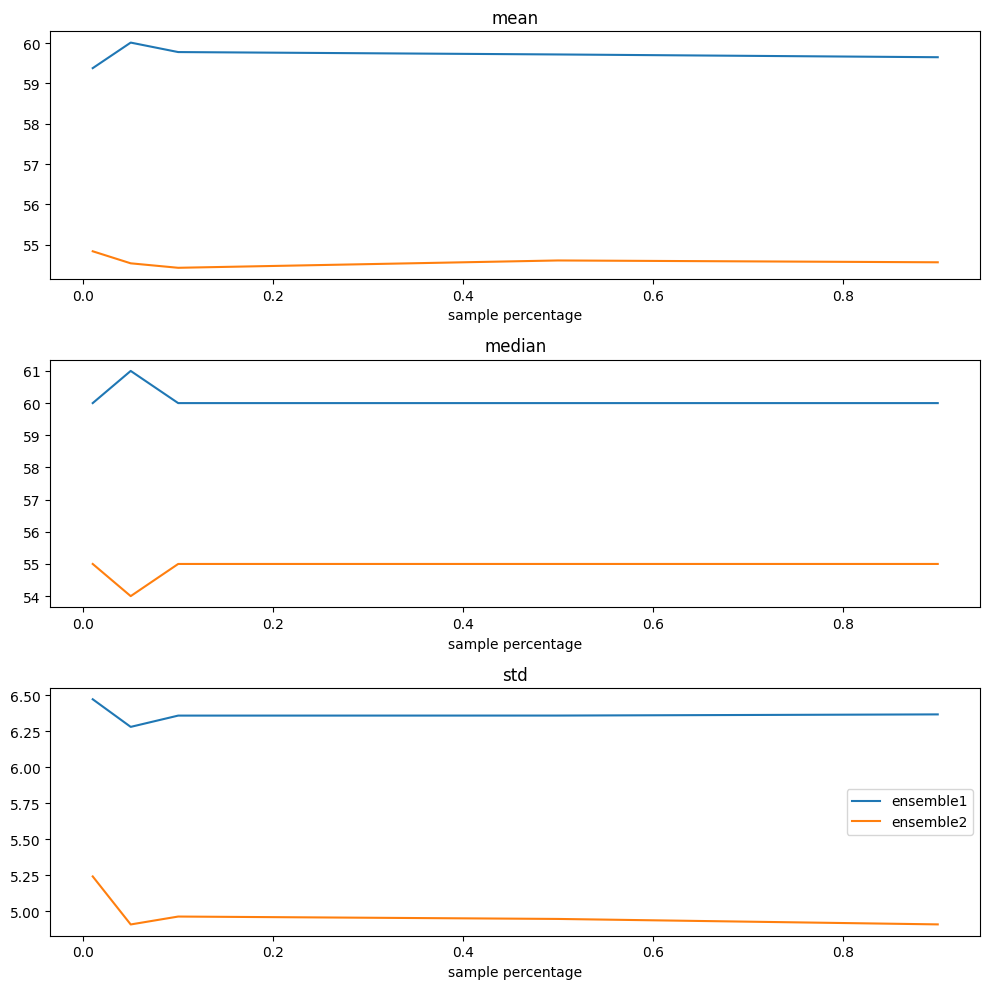

In [13]:
for df in [ensemble1, ensemble2]:
    mean_list = []
    median_list = []
    std_list = []

    for size in sample_sizes:
        sample_size = int(size * len(df))
        sample = df.sample(n=sample_size, replace=False)
        mean_list.append(np.mean(sample['mean']))
        median_list.append(np.median(sample['mean']))
        std_list.append(np.std(sample['mean']))

    means.append(mean_list)
    medians.append(median_list)
    stds.append(std_list)

fig, ax = plt.subplots(3, figsize=(10, 10))

for axis in range(3):
    for i, name in enumerate(['ensemble1', 'ensemble2']):
        ax[axis].plot(sample_sizes, stat_data[axis][i], label=name)

    ax[axis].set_title(stats[axis])
    ax[axis].set_xlabel('sample percentage')

fig.tight_layout()
plt.legend()
plt.show()

What changes in the three statistical parameters do you notice?
--> Especially for ensemble2 the median, mean and std is lower than before. This is due to the fact that the different samples level each other out.

How can you use this information to determine which level of sparse sampling you should use?
--> 0.1 is a reasonable level of sparsity since there is not much of a difference for sample sizes > 0.1

Is there an influence on station location in the ensembles?
--> Including 2004 into the ensemble seems to reduce the std of the ensemble